In [1]:
def orientation_percent(angles, want_ratio=False, dtheta=60):
    is_oriented = np.abs(angles) <= dtheta
    n_angles = len(angles)
    n_angles_after_orientation_cut = np.sum(is_oriented)

    ratio_oriented = n_angles_after_orientation_cut/n_angles
    percent_oriented = ratio_oriented * 100
    
    if want_ratio:
        return ratio_oriented
    else:
        return percent_oriented
    
def sample_proportion_error(p, n):
    """Returns the error for a sample proportion
    https://onlinecourses.science.psu.edu/stat100/node/56
    p: [float] 
        Proportion
    n: [int]
        Number of datapoints
    """
    return np.sqrt(p*(1-p) / n)

## Hypothesis test: difference between two proportions
## http://stattrek.com/hypothesis-test/difference-in-proportions.aspx

def pooled_sample_proportion(p1, p2, n1, n2):
    return (p1*n1 + p2*n2) / (n1 + n2)

def standard_error_between_two_proportions(p, n1, n2):
    return np.sqrt(p * (1 - p) * (1./n1 + 1./n2) )

def z_score_between_two_proportions(p1, p2, SE):
    return (p1 - p2) / SE



def make_and_save_barcharts(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, colors, experiment, orientation_angle,
                           plots_dir):
    n_groups = len(times) # 3

    fig, ax = plt.subplots(figsize=(10,10))
    index = np.arange(n_groups)
    bar_width = 0.4
    opacity = 0.75

    def autolabel(rects):
        """ Attach a text label above each bar displaying its height
    
         Shamelessly adapted from
         https://matplotlib.org/examples/api/barchart_demo.html
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.80*height,
                    '%d' % round(float(height),2),
                    ha='center', va='bottom', size=15)
    
    rects1 = plt.bar(index, wild_orientation_percent,
                     bar_width,
                    alpha=opacity,
                    color=colors['Wild Type'],
                    label='Wild Type',
                    yerr = wild_errors,
                    capsize=5,
                    edgecolor='k',
                    linewidth=1
                    )

    rects2 = plt.bar(index + bar_width, mutant_orientation_percent,
                     bar_width,
                    alpha=opacity,
                    color=colors['Mutant DEE/DEE'],
                    label='Mutant DEE/DEE',
                    yerr = mutant_errors,
                    capsize=5,
                    edgecolor='k',
                    linewidth=1
                    )

    autolabel(rects1)
    autolabel(rects2)
    plt.xlabel("Time")
    plt.ylabel("Orientation %")
    plt.title("Golgi Polarization {} {}".format(experiment, orientation_angle))
    plt.xticks(index + bar_width/2, tuple(times))
    plt.ylim([0,100])
    legend = plt.legend(fontsize=15)

    plt.savefig('{}{}_{}deg.png'.format(plots_dir, experiment, orientation_angle))
    plt.close()
    return None

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rc('axes', titlesize = 22)
plt.rc('axes', labelsize = 22)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

from glob import glob
import os
import statsmodels.api as sm

exp_names = ['exp 1', 'exp 3']

unblinding_key = {'exp 1': {'Wild Type':'Animal 1',
                            'Mutant DEE/DEE':'Animal 2'}
                  ,
                  'exp 3': {'Wild Type':'Animal 2',
                            'Mutant DEE/DEE':'Animal 1'}
                 }

times = ['2hrs', '4hrs', '6hrs']

colors = {'Wild Type': 'purple', 
          'Mutant DEE/DEE': 'blue'}

csv_dir = r'./csvfiles/'

plots_dir = r'./plots/'

orientation_angle_list = np.arange(35, 65, 5)

all_p_value_list = []
all_times_list = []
all_orientation_list = []
all_exp_list = []

## Loop over multiple experiments
for experiment in exp_names:
    csv_files = glob(os.path.join(csv_dir, experiment, "*.csv"))
    df_in_each_file = (pd.read_csv(f) for f in csv_files)
    df = pd.concat(df_in_each_file, ignore_index=True)
    
    df['animal_id'] = df.fileID.str.split('_', expand=True).get(0)
    df['time'] = df.fileID.str.split('_', expand=True).get(1).str.lower()
    
    new_df = df.filter(['golgiAreaInSquareMicrons',
                   'anglesInDeg',
                   'nucleiAreaInSquareMicrons',
                   'time',
                   'animal_id'],
                   axis=1
                      )
    
    ## area cut - keep data with golgi area between (10, 100) microns^2
    area_above_10_microns_squared = new_df['golgiAreaInSquareMicrons'] > 10
    area_below_100_microns_squared = new_df['golgiAreaInSquareMicrons'] < 100

    golgi_area_cut = area_above_10_microns_squared & area_below_100_microns_squared
    
    ## Split into wild type and mutant dataframes
    is_wild_type = new_df.animal_id == unblinding_key[experiment]['Wild Type']
    is_mutant = new_df.animal_id == unblinding_key[experiment]['Mutant DEE/DEE']

    wild_type = new_df[golgi_area_cut & is_wild_type]
    mutant = new_df[golgi_area_cut & is_mutant]
    
    angle_bins = np.arange(-180, 180, 30)
    
    for orientation_angle in orientation_angle_list:
        
        wild_oriented_percent = orientation_percent(
            wild_type['anglesInDeg'],
            dtheta = orientation_angle)
        
        mutant_oriented_percent = orientation_percent(
            mutant['anglesInDeg'],
            dtheta = orientation_angle)
        
        wild_n = []
        mutant_n = []

        wild_orientation_percent = []
        mutant_orientation_percent = []

        wild_errors = []
        mutant_errors = []

        pvalues = []
        
        #print(orientation_angle)
        
        for time in times:
            wild_at_this_time = wild_type[wild_type.time == time]
            mutant_at_this_time = mutant[mutant.time == time]

            n1 = len(wild_at_this_time)
            n2 = len(mutant_at_this_time)
            wild_n.append(n1)
            mutant_n.append(n2)

            orientation_percent_wild = orientation_percent(wild_at_this_time['anglesInDeg'],
                                                          dtheta=orientation_angle)
            orientation_percent_mutant = orientation_percent(mutant_at_this_time['anglesInDeg'],
                                                            dtheta=orientation_angle)
            wild_orientation_percent.append(orientation_percent_wild)
            mutant_orientation_percent.append(orientation_percent_mutant)

            ratio_wild = orientation_percent(wild_at_this_time['anglesInDeg'], want_ratio=True,
                                            dtheta=orientation_angle)
            ratio_mutant = orientation_percent(mutant_at_this_time['anglesInDeg'], want_ratio=True,
                                              dtheta=orientation_angle)

            serr1 = sample_proportion_error(ratio_wild, n1)
            serr2 = sample_proportion_error(ratio_mutant, n2)
            wild_errors.append(sample_proportion_error(ratio_wild, n1)*100)
            mutant_errors.append(sample_proportion_error(ratio_mutant, n2)*100)
            
            #print("{}".format(time))
            #print("With N = {}, wild type orientation : {}% +/- {}%".format(n1,
            #    int(orientation_percent_wild), round(serr1*100,1)))
            #print("With N = {}, mutant orientation : {}% +/- {}%".format(n2,
            #    int(orientation_percent_mutant), round(serr2*100,1)))
            #print("\n")
            
            all_times_list.append(time)
        make_and_save_barcharts(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, colors, experiment, orientation_angle,
                           plots_dir)
        
        
        p_wild = np.array(wild_orientation_percent)/100.
        p_mutant = np.array(mutant_orientation_percent)/100.
        
        n_wild = np.array(wild_n)
        n_mutant = np.array(mutant_n)

        p = pooled_sample_proportion(p_wild, p_mutant, n_wild, n_mutant)
        SE = standard_error_between_two_proportions(p, n_wild, n_mutant)
        z_scores = z_score_between_two_proportions(p_wild, p_mutant, SE)

        from scipy import special
        p_values = 1 - special.ndtr(z_scores)

        #print("p values: {}".format(p_values))

        all_p_value_list.extend(p_values)
        all_orientation_list.extend([orientation_angle]*3)
        all_exp_list.extend([experiment]*3)




C:\Users\letmedoit\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
d = {"p_value":all_p_value_list,
    "Orientation Angle":all_orientation_list,
    "Times":all_times_list,
    "Experiment":all_exp_list
    }

df = pd.DataFrame(d)

exp1 = df[df['Experiment'] == 'exp 1']
exp3 = df[df['Experiment'] == 'exp 3']

exp1_2hrs = exp1[exp1['Times'] == '2hrs']
exp1_4hrs = exp1[exp1['Times'] == '4hrs']
exp1_6hrs = exp1[exp1['Times'] == '6hrs']

exp3_2hrs = exp3[exp3['Times'] == '2hrs']
exp3_4hrs = exp3[exp3['Times'] == '4hrs']
exp3_6hrs = exp3[exp3['Times'] == '6hrs']
print(exp1_2hrs)

   Experiment  Orientation Angle Times   p_value
0       exp 1                 35  2hrs  0.002635
3       exp 1                 40  2hrs  0.011013
6       exp 1                 45  2hrs  0.002665
9       exp 1                 50  2hrs  0.007280
12      exp 1                 55  2hrs  0.035474
15      exp 1                 60  2hrs  0.014630


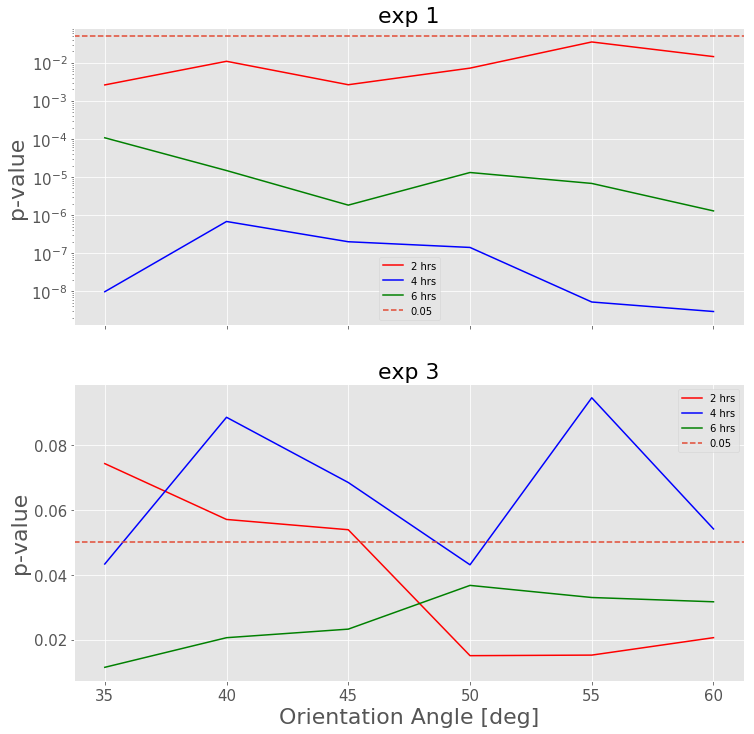

In [6]:
fig, axes = plt.subplots(2,1,figsize=(12,12), sharex=True)

ax = axes.ravel()

ax[0].plot(exp1_2hrs['Orientation Angle'], exp1_2hrs['p_value'],
           "r",
           label='2 hrs'
          )
ax[0].plot(exp1_4hrs['Orientation Angle'], exp1_4hrs['p_value'],
           "g",
           label='4 hrs'
          )
ax[0].plot(exp1_6hrs['Orientation Angle'], exp1_6hrs['p_value'],
           "b",
           label='6 hrs'
          )

ax[0].set_yscale('log')
ax[0].set_title('exp 1')
ax[0].set_xticks(np.arange(35, 65, 5))
ax[0].set_ylabel('p-value')
ax[0].axhline(0.05, ls="--", label='0.05')
ax[0].legend()

ax[1].plot(exp3_2hrs['Orientation Angle'],exp3_2hrs['p_value'],
           "r",
           label='2 hrs'
          )
ax[1].plot(exp3_4hrs['Orientation Angle'], exp3_4hrs['p_value'],
           "g",
           label='4 hrs'
          )
ax[1].plot(exp3_6hrs['Orientation Angle'], exp3_6hrs['p_value'],
           "b",
           label='6 hrs'
          )

ax[1].set_yscale('linear')
ax[1].set_title('exp 3')
ax[1].set_xticks(np.arange(35, 65, 5))
ax[1].set_xlabel('Orientation Angle [deg]')
ax[1].set_ylabel('p-value')
ax[1].axhline(0.05, ls="--", label='0.05')
ax[1].legend()

plt.savefig('{}p_values_vs_angles.png'.format(plots_dir))